In [1]:
import sys
!{sys.executable} -m pip install xgboost

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

def load_data():
    netflix_csv_file = open("data_folder/netflix_data.csv", mode = "w")
    rating_files = ['data_folder/combined_data_2.txt']
    for file in rating_files:
        with open(file) as f:
            for line in f:
                line = line.strip()
                if line.endswith(":"):
                    movie_id = line.replace(":", "")
                else:
                    row_data = []
                    row_data = [item for item in line.split(",")]
                    row_data.insert(0, movie_id)
                    netflix_csv_file.write(",".join(row_data))  
                    netflix_csv_file.write('\n')
                    
    netflix_csv_file.close()
    df = pd.read_csv('data_folder/netflix_data.csv', sep=",", names = ["movie_id","customer_id", "rating", "date"])
    return df

netflix_rating_df = load_data()
netflix_rating_df.head()

,movie_id,customer_id,rating,date
0,4500,2532865,4,2005-07-26
1,4500,573364,3,2005-06-20
2,4500,1696725,3,2004-02-27
3,4500,1253431,3,2004-03-31
4,4500,1265574,2,2003-09-01


In [3]:
netflix_rating_df.duplicated(["movie_id","customer_id", "rating", "date"]).sum()

0

In [4]:
split_value = int(len(netflix_rating_df) * 0.80)
train_data = netflix_rating_df[:split_value]
test_data = netflix_rating_df[split_value:]

<ipython-input-5-35d5d19fb8e1>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


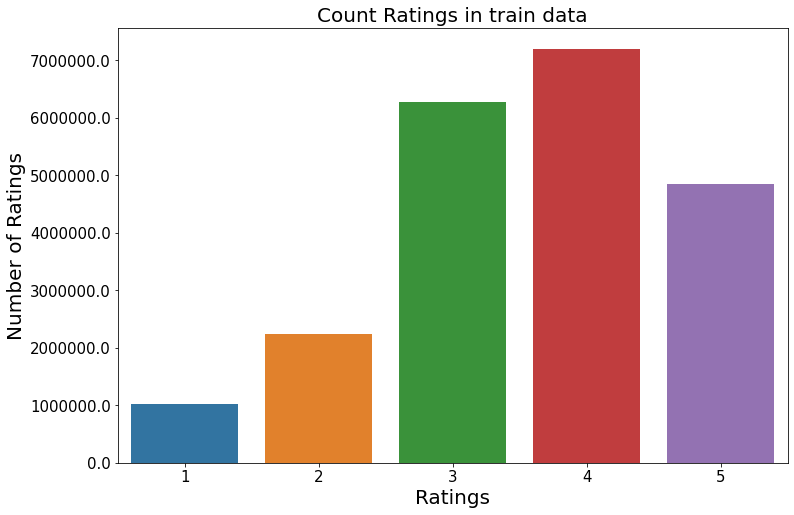

In [5]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=train_data)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [6]:
no_rated_movies_per_user = train_data.groupby(by = "customer_id")["rating"].count().sort_values(ascending = False)
no_rated_movies_per_user.head()

customer_id
305344     3635
387418     3598
2439493    3388
1664010    3270
2118461    3053
Name: rating, dtype: int64

In [7]:
no_ratings_per_movie = train_data.groupby(by = "movie_id")["rating"].count().sort_values(ascending = False)
no_ratings_per_movie.head()

movie_id
5317    232944
6287    193295
6972    171991
6037    158601
5496    155714
Name: rating, dtype: int64

In [8]:
def get_user_item_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.rating, (df.customer_id, df.movie_id)))
    return sparse_data

In [9]:
train_sparse_data = get_user_item_sparse_matrix(train_data)

In [10]:
test_sparse_data = get_user_item_sparse_matrix(test_data)

In [11]:
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print("Global Average Rating: {}".format(global_average_rating))

Global Average Rating: 3.5850628243664464


In [12]:
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1  
    no_of_ratings = (sparse_matrix != 0).sum(axis = ax).A1 
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/no_of_ratings[i] for i in range(rows if is_user else cols) if no_of_ratings[i] != 0}
    return average_ratings

In [13]:
average_rating_user = get_average_rating(train_sparse_data, True)

In [14]:
avg_rating_movie = get_average_rating(train_sparse_data, False)

In [15]:
total_users = len(np.unique(netflix_rating_df["customer_id"]))
train_users = len(average_rating_user)
uncommonUsers = total_users - train_users
                  
print("Total no. of Users = {}".format(total_users))
print("No. of Users in train data= {}".format(train_users))
print("No. of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total no. of Users = 474062
No. of Users in train data= 471992
No. of Users not present in train data = 2070(0.0%)


In [16]:
total_movies = len(np.unique(netflix_rating_df["movie_id"]))
train_movies = len(avg_rating_movie)
uncommonMovies = total_movies - train_movies
                  
print("Total no. of Movies = {}".format(total_movies))
print("No. of Movies in train data= {}".format(train_movies))
print("No. of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total no. of Movies = 4711
No. of Movies in train data= 3660
No. of Movies not present in train data = 1051(22.0%)


In [17]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    rows = np.unique(row_index)
    similar_arr = np.zeros(61700).reshape(617,100)
    
    for row in rows[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar
    
    return similar_arr

similar_user_matrix = compute_user_similarity(train_sparse_data, 100)

In [18]:
movie_titles_df = pd.read_csv("data_folder/movie_titles.csv", sep = ",", header = None, names=['movie_id', 'year_of_release', 'movie_title'], index_col = "movie_id", encoding = "iso8859_2")
movie_titles_df.head()

,year_of_release,movie_title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [19]:
def compute_movie_similarity_count(sparse_matrix, movie_titles_df, movie_id):
    similarity = cosine_similarity(sparse_matrix.T, dense_output = False)
    no_of_similar_movies = movie_titles_df.loc[movie_id][1], similarity[movie_id].count_nonzero()
    return no_of_similar_movies

In [20]:
similar_movies = compute_movie_similarity_count(train_sparse_data, movie_titles_df, 1775)
print("Similar Movies = {}".format(similar_movies))

Similar Movies = ('Dario Argento Collection: Vol. 1: Phenomena', 0)


In [21]:
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies):
    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15) 
    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(userS)+1, max(movieS)+1))
    return sparse_sample

In [22]:
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 400, 40)

In [23]:
test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 200, 20)

In [24]:
def create_new_similar_features(sample_sparse_matrix):
    global_avg_rating = get_average_rating(sample_sparse_matrix, False)
    global_avg_users = get_average_rating(sample_sparse_matrix, True)
    global_avg_movies = get_average_rating(sample_sparse_matrix, False)
    sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_sparse_matrix)
    new_features_csv_file = open("data_folder/new_features.csv", mode = "w")
    
    for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
        similar_arr = list()
        similar_arr.append(user)
        similar_arr.append(movie)
        similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())
        
        similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
        indices = np.argsort(-similar_users)[1:]
        ratings = sample_sparse_matrix[indices, movie].toarray().ravel()
        top_similar_user_ratings = list(ratings[ratings != 0][:5])
        top_similar_user_ratings.extend([global_avg_rating[movie]] * (5 - len(ratings)))
        similar_arr.extend(top_similar_user_ratings)
        
        similar_movies = cosine_similarity(sample_sparse_matrix[:,movie].T, sample_sparse_matrix.T).ravel()
        similar_movies_indices = np.argsort(-similar_movies)[1:]
        similar_movies_ratings = sample_sparse_matrix[user, similar_movies_indices].toarray().ravel()
        top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
        top_similar_movie_ratings.extend([global_avg_users[user]] * (5-len(top_similar_movie_ratings)))
        similar_arr.extend(top_similar_movie_ratings)
        
        similar_arr.append(global_avg_users[user])
        similar_arr.append(global_avg_movies[movie])
        similar_arr.append(rating)
        
        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")
        
    new_features_csv_file.close()
    new_features_df = pd.read_csv('data_folder/new_features.csv', names = ["user_id", "movie_id", "gloabl_average", "similar_user_rating1", 
                                                               "similar_user_rating2", "similar_user_rating3", 
                                                               "similar_user_rating4", "similar_user_rating5", 
                                                               "similar_movie_rating1", "similar_movie_rating2", 
                                                               "similar_movie_rating3", "similar_movie_rating4", 
                                                               "similar_movie_rating5", "user_average", 
                                                               "movie_average", "rating"])
    return new_features_df

In [25]:
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)
train_new_similar_features.replace([np.inf, -np.inf], np.nan, inplace=True)
train_new_similar_features.dropna(inplace=True)
train_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,154759,4546,3.27551,3.0,4.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.125,2.0
1,219002,4546,3.27551,3.0,4.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.125,3.0
2,237294,4546,3.27551,3.0,4.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,3.125,4.0
3,290248,4546,3.27551,3.0,4.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.125,3.0
4,679166,4546,3.27551,5.0,4.0,3.0,3.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,3.125,5.0


In [26]:
test_new_similar_features = create_new_similar_features(test_sparse_matrix_matrix)
test_new_similar_features.replace([np.inf, -np.inf], np.nan, inplace=True)
test_new_similar_features.dropna(inplace=True)
test_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
1,427186,8325,3.56,2.0,3.0,3.0,5.0,2.0,3.0,3.0,3.000000,3.000000,3.000000,3.000000,3.0,3.0
2,1054137,8325,3.56,2.0,3.0,3.0,5.0,2.0,3.0,4.0,3.333333,3.333333,3.333333,3.333333,3.0,3.0
3,1580917,8325,3.56,3.0,3.0,3.0,5.0,2.0,2.0,2.0,2.000000,2.000000,2.000000,2.000000,3.0,2.0
4,1655692,8325,3.56,3.0,5.0,2.0,3.0,3.0,2.0,2.0,2.000000,2.000000,2.000000,2.000000,3.0,2.0
5,1804549,8325,3.56,3.0,5.0,2.0,3.0,3.0,5.0,5.0,5.000000,5.000000,5.000000,5.000000,3.0,5.0


In [27]:
train_new_similar_features = train_new_similar_features.reset_index()
test_new_similar_features = test_new_similar_features.reset_index()

In [28]:
x_train = train_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)
x_test = test_new_similar_features.drop(["user_id", "movie_id", "rating"], axis = 1)
y_train = train_new_similar_features["rating"]
y_test = test_new_similar_features["rating"]

In [29]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [30]:
def _assert_all_finite(X):
    """Like assert_all_finite, but only for ndarray."""
    X = np.asanyarray(X)
    # First try an O(n) time, O(1) space solution for the common case that
    # everything is finite; fall back to O(n) space np.isfinite to prevent
    # false positives from overflow in sum method.
    if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
            and not np.isfinite(X).all()):
        print(X)
        raise ValueError("Input contains NaN, infinity"
                         " or a value too large for %r." % X.dtype)
        
_assert_all_finite(x_train)

In [31]:
clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
clf.fit(x_train, y_train)

[15:20:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=False, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
y_pred_test = clf.predict(x_test)

In [33]:
rmse_test = error_metrics(y_test, y_pred_test)
print("RMSE = {}".format(rmse_test))

RMSE = 0.4372692206022645


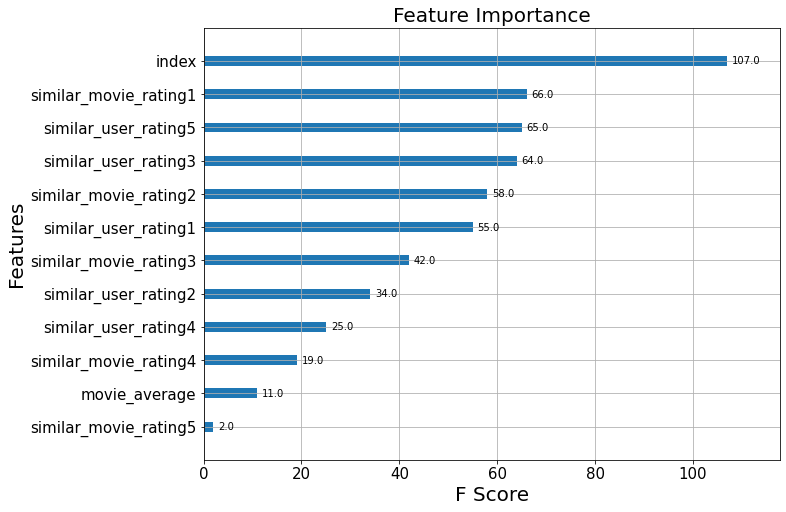

In [34]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()
    
plot_importance(xgb, clf)